In [12]:
import pandas as pd
from sklearn.decomposition import PCA
from time import time
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('default')
import seaborn as sns
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
import psutil
import shap
from exmatrix import ExplainableMatrix

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
POSITIVE = 5
NEGATIVE = 1

#loading the data
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", 
             "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", 
             "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", 
             "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
             "srv_diff_host_rate", "dst_host_count","dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
             "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
             "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

#Initially, we will use all features
num_features = ["duration", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", 
                "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
                "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", 
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
                "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
                "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]

kdd_df = pd.read_csv("../KDD99/corrected.csv", names = col_names)
kdd_df = kdd_df.iloc[:100]

features = kdd_df[num_features].astype(float)

scaler = MinMaxScaler()

features_scaled = features.copy()
for column in features.columns:
    column_data = features[column].values.reshape(-1, 1)
    features_scaled[column] = scaler.fit_transform(column_data)

features_scaled.columns = features.columns

y_true = kdd_df['label'].copy()

label_encoder = LabelEncoder()

encoded_labels = y_true.copy()

# Fit the encoder on the labels and transform the column
encoded_labels = label_encoder.fit_transform(encoded_labels)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, encoded_labels, test_size=0.15, random_state=42)

In [3]:
#Training a classifier
clf = RandomForestClassifier(random_state=0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Classifier trained in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='weighted')
recall = recall_score(y_test, pred_test, average='weighted')
f1 = f1_score(y_test, pred_test, average='weighted')
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Classifier trained in 0.106 seconds.
Classifier predicted on test set in 0.006 seconds.
Accuracy test:  0.9333333333333333
Precision:  0.9393939393939393
Recall:  0.9333333333333333
F1 Score:  0.9312169312169313


In [24]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features.columns)

# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': importances})

# Sort the DataFrame by importance scores in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

def select_important_features(feature_importance_df_sorted, threshold=0.01):
    important_features = feature_importance_df_sorted[feature_importance_df_sorted['Importance'] > threshold]
    selected_feature_names = important_features['Feature'].tolist()
    return selected_feature_names

# Usage:
selected_features = select_important_features(feature_importance_df_sorted, threshold=0.1)
print("Selected features:", selected_features)

Selected features: ['srv_count', 'src_bytes', 'dst_host_srv_count', 'dst_host_same_src_port_rate', 'count']


In [4]:
exm = ExplainableMatrix(n_features=len(num_features), n_classes=len(np.unique(encoded_labels)) , feature_names=num_features, class_names=y_true.unique(), precision=3)
exm.rules_extration(clf, X_test.to_numpy(), y_test, clf.feature_importances_)
print( 'n_rules DT', exm.n_rules_ )

n_rules DT 1034


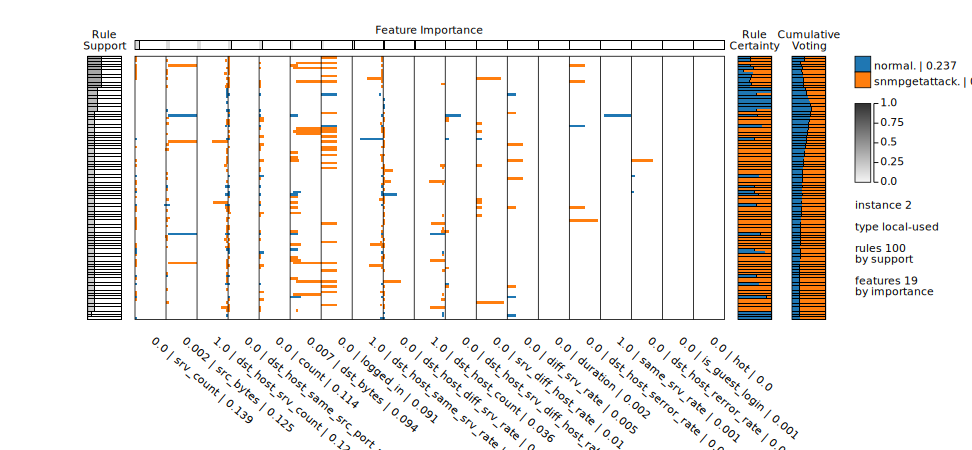

In [5]:
#exp = exm.explanation( exp_type = 'local-used', x_k = X_test[ 13 ], r_order = 'support', f_order = 'importance', info_text = '\ninstance 13\n' )
exp = exm.explanation( exp_type = 'local-used', x_k = X_test.iloc[NEGATIVE], r_order = 'support', f_order = 'importance', info_text = '\ninstance 2\n' )
exp.create_svg( draw_col_labels = True, draw_cols_line = True, col_label_degrees = 40, height = 1000, margin_bottom = 290, stroke_width = 1.75, font_size = 24 )
#exp.save( 'NEG_ORG_1.svg' )
exp.display_jn()

In [7]:
X_test.iloc[NEGATIVE]

duration                       0.000000
src_bytes                      0.002161
dst_bytes                      0.007463
land                           0.000000
wrong_fragment                 0.000000
urgent                         0.000000
hot                            0.000000
num_failed_logins              0.000000
logged_in                      0.000000
num_compromised                0.000000
root_shell                     0.000000
su_attempted                   0.000000
num_root                       0.000000
num_file_creations             0.000000
num_shells                     0.000000
num_access_files               0.000000
num_outbound_cmds              0.000000
is_host_login                  0.000000
is_guest_login                 0.000000
count                          0.000000
srv_count                      0.000000
serror_rate                    0.000000
srv_serror_rate                0.000000
rerror_rate                    0.000000
srv_rerror_rate                0.000000


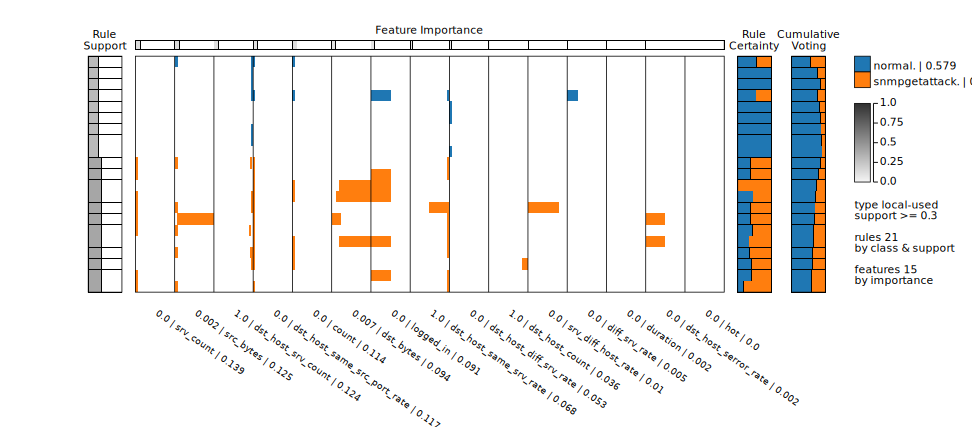

In [39]:
exp = exm.explanation( exp_type = 'local-used',  x_k = X_test.iloc[NEGATIVE], r_order = 'class & support', f_order = 'importance', r_support_min = 0.3 )
exp.create_svg( draw_x_k = False, draw_col_labels = True, draw_cols_line = True, col_label_font_size = 20, col_label_degrees = 35, height = 950, margin_bottom = 300, stroke_width = 1.75, font_size = 24 )
exp.display_jn()

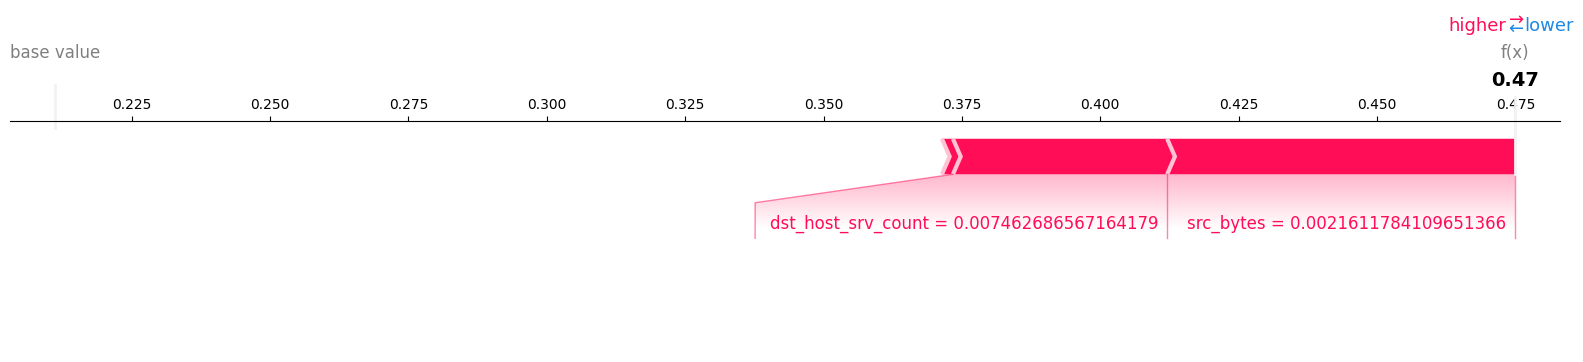

In [63]:
explainer = shap.TreeExplainer(clf)
choosen_instance = X_test.iloc[[NEGATIVE]]
shap_values = explainer.shap_values(X_test)

feat_names = ['srv_count', 'src_bytes', 'dst_host_srv_count', 'dst_host_same_src_port_rate', 'count']

shap.force_plot(explainer.expected_value[1], shap_values[0][:, 1], choosen_instance.iloc[0], matplotlib=True, feature_names=selected_features)
plt.show()

In [58]:
shap_values = explainer.shap_values(X_test)

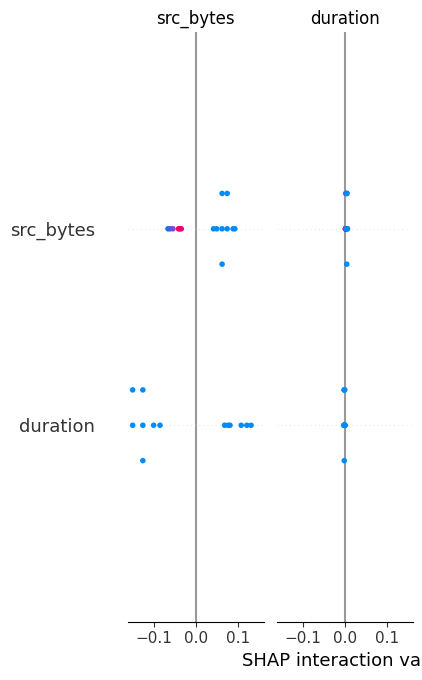

In [61]:
shap.summary_plot(shap_values, X_test)

In [55]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_.iloc[0, :])

TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).